In [19]:
import tensorflow as tf

# Parameters
img_height, img_width = 128, 128
batch_size = 32

# ImageDataGenerator for loading images with normalization and optional augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # small rotations
    horizontal_flip=True,    # horizontal flips
    validation_split=0.2     # split 20% for validation
)

# Training generator (only normal images for autoencoder training)
train_gen = datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=(img_height, img_width),
    classes=['normal'],      # only use the 'normal' folder for unsupervised training
    class_mode=None,         # no labels
    batch_size=batch_size,
    subset='training',
    shuffle=True
)
# Validation generator (normal images)
val_gen = datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=(img_height, img_width),
    classes=['normal'],
    class_mode=None,
    batch_size=batch_size,
    subset='validation',
    shuffle=True
)

# For the hybrid model, we need labels, so we load both classes
labeled_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_labeled = labeled_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=(img_height, img_width),
    classes=['normal', 'dr'],
    class_mode='binary',    # binary labels for normal vs DR
    batch_size=batch_size,
    subset='training',
    shuffle=True
)
val_labeled = labeled_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=(img_height, img_width),
    classes=['normal', 'dr'],
    class_mode='binary',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)


Found 4124 images belonging to 1 classes.
Found 1030 images belonging to 1 classes.
Found 8339 images belonging to 2 classes.
Found 2083 images belonging to 2 classes.


In [36]:
def build_autoencoder_fixed(input_shape=(128, 128, 3), latent_dim=128):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder: Conv -> ReLU -> downsample
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(inputs)   # 64×64
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)       # 32×32
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)      # 16×16
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(latent_dim, (3, 3), activation='relu', padding='same', strides=2)(x)  # 8×8
    x = tf.keras.layers.BatchNormalization()(x)

    # Flatten to latent vector
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]  # (8, 8, latent_dim)
    print(f"shape_before_flatten: {shape_before_flatten}")  # Print the shape

    x = tf.keras.layers.Flatten()(x)
    latent = tf.keras.layers.Dense(latent_dim, activation='relu', name='latent_vector')(x)

    # Decoder: reverse operations with Conv2DTranspose
    x = tf.keras.layers.Dense(shape_before_flatten[0] * shape_before_flatten[1] * shape_before_flatten[2], activation='relu')(latent)
    x = tf.keras.layers.Reshape(shape_before_flatten)(x)

    # We need 4 transposed convolutions to go from 8x8 to 128x128
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)  # 8×8->16×16
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)   # 16×16->32×32
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)   # 32×32->64×64
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)   # 64×64->128×128
    x = tf.keras.layers.BatchNormalization()(x)

    # Final layer to get the right number of channels (3) with sigmoid activation
    outputs = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final output: 128×128×3

    # Create and return the model
    return tf.keras.Model(inputs, outputs)

# Build and compile the fixed autoencoder
autoencoder = build_autoencoder_fixed()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

# Print the model summary to verify the output shape
autoencoder.summary()

# Test the model with a sample input to verify dimensions
sample_input = np.zeros((1, 128, 128, 3))
sample_output = autoencoder.predict(sample_input)
print(f"Input shape: {sample_input.shape}, Output shape: {sample_output.shape}")

# Check that the dimensions match
assert sample_input.shape == sample_output.shape, "Input and output dimensions don't match!"
print("Dimension check passed! The model outputs the correct shape.")

shape_before_flatten: (8, 8, 128)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 128, 128, 16)   │         4,62

 Total params: 2,593,571 (9.89 MB)

 Trainable params: 2,592,387 (9.89 MB)

 Non-trainable params: 1,184 (4.62 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Input shape: (1, 128, 128, 3), Output shape: (1, 128, 128, 3)
Dimension check passed! The model outputs the correct shape.


In [44]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Training parameters
epochs = 30
patience = 3
wait = 0
best_val_loss = float('inf')
best_weights = None
history = {'loss': [], 'val_loss': []}

# Reset generators
train_gen.reset()
val_gen.reset()

# Get the correct input name for dictionary-style feeding
input_name = autoencoder.input_names[0]
print(f"Using model input name: {input_name}")

# Sanity check: shape
x_sample = next(train_gen)
print(f"Input batch shape: {x_sample.shape}")
y_pred = autoencoder.predict({input_name: x_sample[:1]})
print(f"Output shape: {y_pred.shape}")

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    start_time = time.time()

    # Training
    train_losses = []
    train_gen.reset()
    train_iterator = iter(train_gen)

    for _ in range(len(train_gen)):
        try:
            x_batch = next(train_iterator)
            loss = autoencoder.train_on_batch({input_name: x_batch}, x_batch)
            train_losses.append(loss)

            if len(train_losses) % 5 == 0:
                print(f"  Batch {len(train_losses)}/{len(train_gen)} - loss: {loss:.4f}", end="\r")

        except Exception as e:
            print(f"Error in training batch: {e}")
            continue

    avg_train_loss = np.mean(train_losses) if train_losses else float('inf')
    history['loss'].append(avg_train_loss)

    # Validation
    val_losses = []
    val_gen.reset()
    val_iterator = iter(val_gen)

    for _ in range(len(val_gen)):
        try:
            x_val = next(val_iterator)
            val_loss = autoencoder.test_on_batch({input_name: x_val}, x_val)
            val_losses.append(val_loss)

        except Exception as e:
            print(f"Error in validation batch: {e}")
            continue

    avg_val_loss = np.mean(val_losses) if val_losses else float('inf')
    history['val_loss'].append(avg_val_loss)

    epoch_time = time.time() - start_time

    print(f"\nEpoch {epoch+1}/{epochs} - {epoch_time:.1f}s - loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
        best_val_loss = avg_val_loss
        wait = 0
        best_weights = autoencoder.get_weights()
    else:
        wait += 1
        print(f"Validation loss did not improve. {wait}/{patience}")
        if wait >= patience:
            print("Early stopping triggered")
            break

# Restore best weights
if best_weights is not None:
    print(f"Restoring best weights (val_loss: {best_val_loss:.4f})")
    autoencoder.set_weights(best_weights)

print("Training completed!")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Visualize reconstructions
def visualize_reconstructions(n=5):
    val_gen.reset()
    images = next(iter(val_gen))[:n]
    reconstructions = autoencoder.predict({input_name: images})

    plt.figure(figsize=(20, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructions[i])
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show reconstructions
try:
    visualize_reconstructions()
except Exception as e:
    print(f"Error visualizing reconstructions: {e}")


AttributeError: 'Functional' object has no attribute 'input_names'

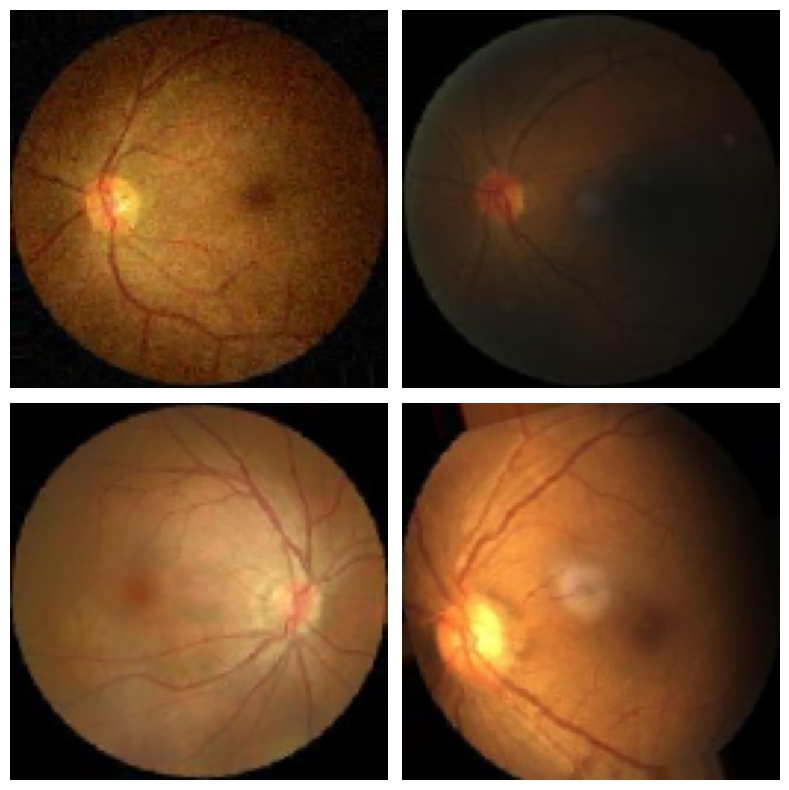

In [21]:
# Check if train_gen and val_gen are working as expected
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from train_gen
x_batch = train_gen.next()

# Display a few images from the batch
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.flatten()
for i in range(4):
    img = x_batch[i]
    axes[i].imshow(img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Similarly, you can check the validation generator (val_gen)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================
# Data Preparation
# ======================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

# Autoencoder Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal'],
    class_mode='input',  # Critical fix
    batch_size=BATCH_SIZE,
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal'],
    class_mode='input',  # Critical fix
    batch_size=BATCH_SIZE,
    subset='validation',
    seed=SEED
)

# ======================
# Model Architecture (same as before)
# ======================
def build_autoencoder(input_shape=(128, 128, 3), latent_dim=256):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Latent Space
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    x = tf.keras.layers.Flatten()(x)
    latent = tf.keras.layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = tf.keras.layers.Dense(np.prod(shape_before_flatten))(latent)
    x = tf.keras.layers.Reshape(shape_before_flatten)(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    outputs = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return tf.keras.Model(inputs, outputs)

# ======================
# Training Execution
# ======================
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

# Rest of the evaluation code remains the same as previous answer

Found 4124 images belonging to 1 classes.
Found 1030 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - loss: 0.1055 - val_loss: 0.0719
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - loss: 0.0305 - val_loss: 0.0352
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - loss: 0.0153 - val_loss: 0.0173
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - loss: 0.0086 - val_loss: 0.0087
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - loss: 0.0061 - val_loss: 0.0053
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - loss: 0.0046 - val_loss: 0.0042
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - loss: 0.0034 - val_loss: 0.0030
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - loss: 0.0032 - val_loss: 0.0028
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 

In [5]:
autoencoder.save('autoencoder_model.keras')


Found 435 images belonging to 2 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step
Found 5154 images belonging to 1 classes.
129/129 ━━━━━━━━━━━━━━━━━━━━ 53s 414ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.93      0.73       215
          DR       0.86      0.38      0.52       220

    accuracy                           0.65       435
   macro avg       0.73      0.66      0.63       435
weighted avg       0.73      0.65      0.62       435


Confusion Matrix:
[[201  14]
 [137  83]]


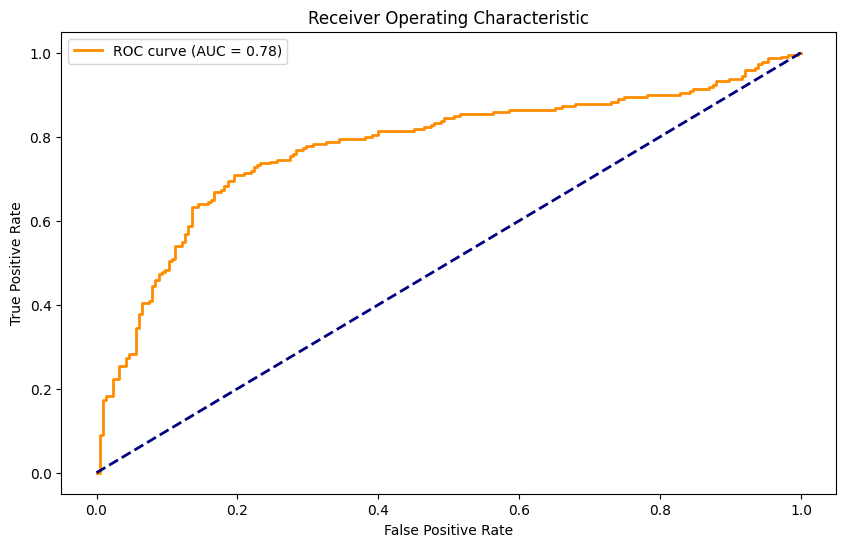

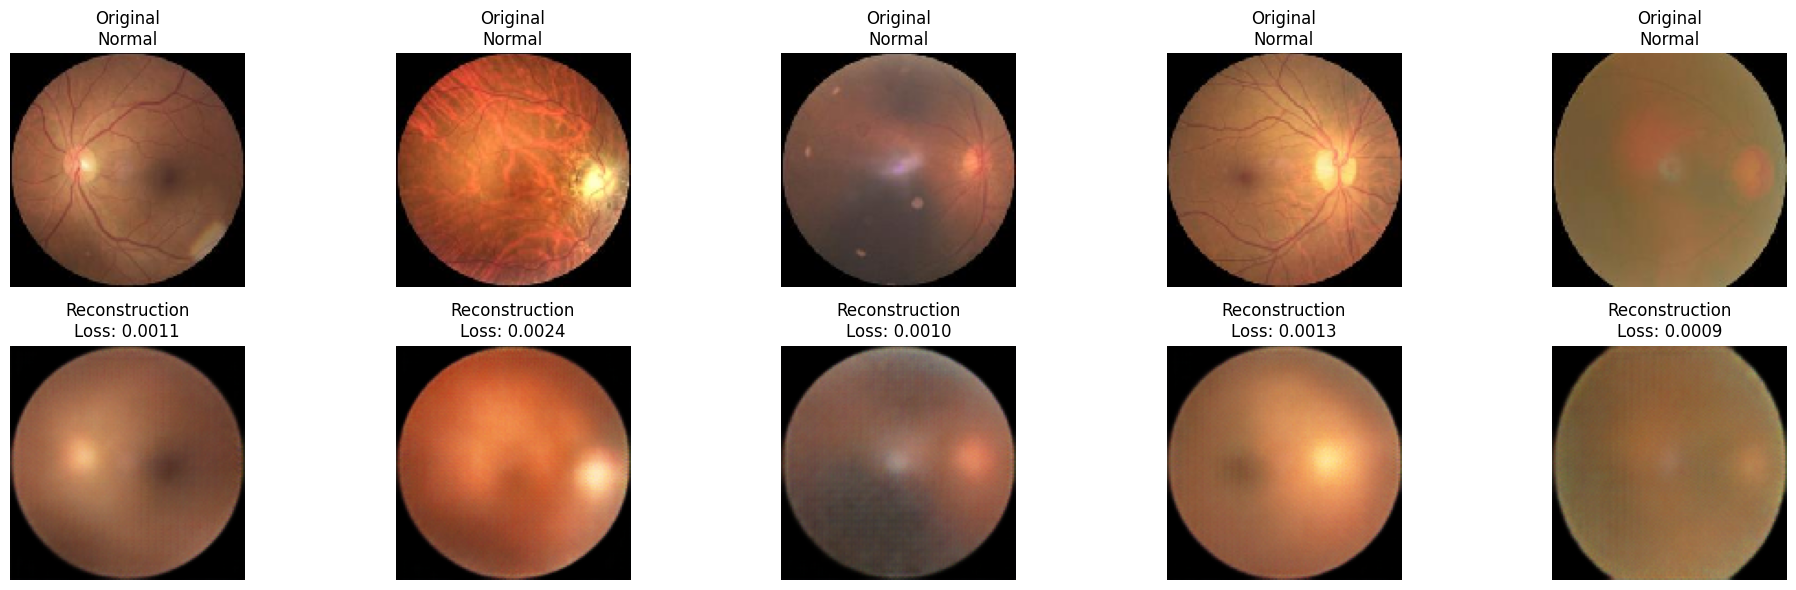

In [7]:

# ======================
# Evaluation Preparation
# ======================

# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    'dr_dataset/testing/',
    target_size=IMG_SIZE,
    class_mode='binary',
    classes=['normal', 'dr'],
    batch_size=1,
    shuffle=False
)

# Load all test data
test_images, test_labels = [], []
for i in range(len(test_gen)):
    # Replace test_gen.next() with next(test_gen)
    img, label = next(test_gen)
    test_images.append(img[0])
    test_labels.append(label[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Generate reconstructions
reconstructions = autoencoder.predict(test_images)

# Calculate MSE losses
mse_losses = np.mean(np.square(test_images - reconstructions), axis=(1,2,3))

# ======================
# Threshold Determination
# ======================

# Get losses for normal images in training set
normal_samples = next(train_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal'],
    class_mode=None,
    batch_size=len(train_gen) * BATCH_SIZE
))

normal_recon = autoencoder.predict(normal_samples)
normal_losses = np.mean(np.square(normal_samples - normal_recon), axis=(1,2,3))

threshold = np.mean(normal_losses) + 2 * np.std(normal_losses)

# Classify test samples
y_pred = (mse_losses > threshold).astype(int)

# ======================
# Performance Evaluation
# ======================

print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['Normal', 'DR']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, mse_losses)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

# ======================
# Visualization
# ======================

def plot_reconstructions(images, reconstructions, labels, n=5):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.title(f"Original\n{'DR' if labels[i] else 'Normal'}")
        plt.axis('off')

        # Reconstruction
        plt.subplot(2, n, i+1+n)
        plt.imshow(reconstructions[i])
        plt.title(f"Reconstruction\nLoss: {mse_losses[i]:.4f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_reconstructions(test_images, reconstructions, test_labels)

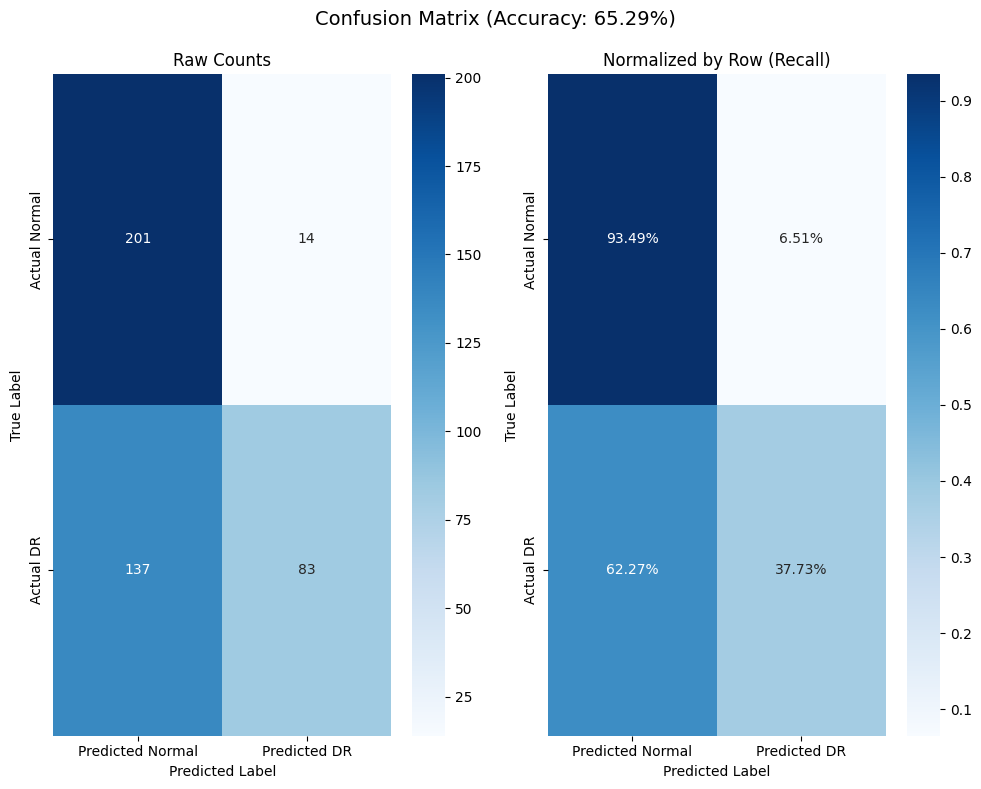

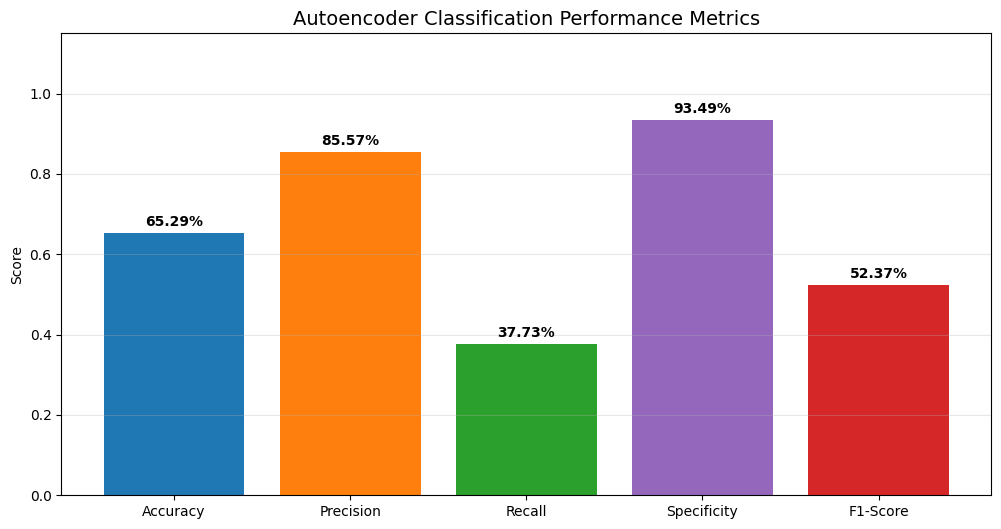

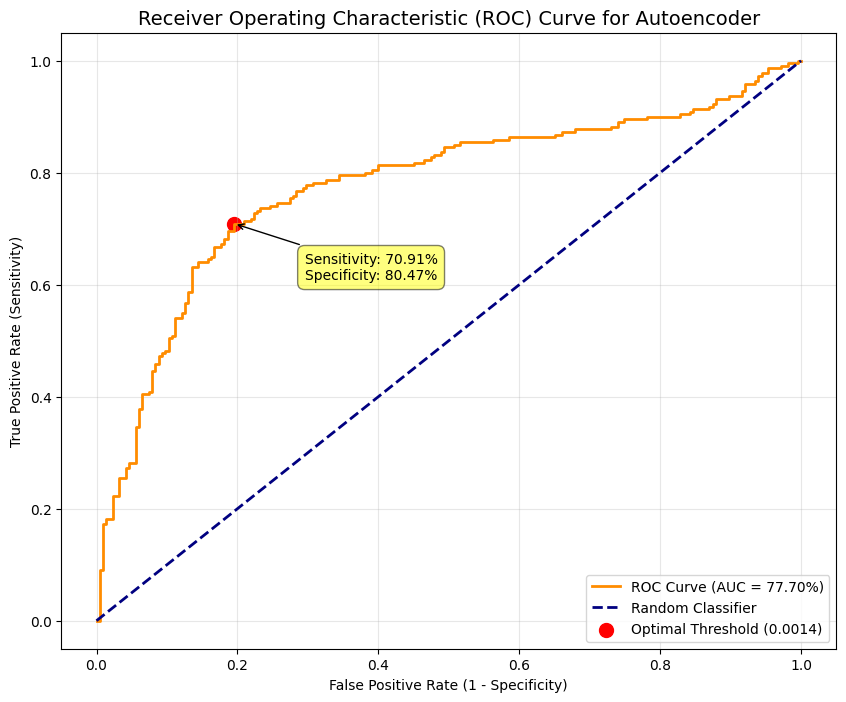

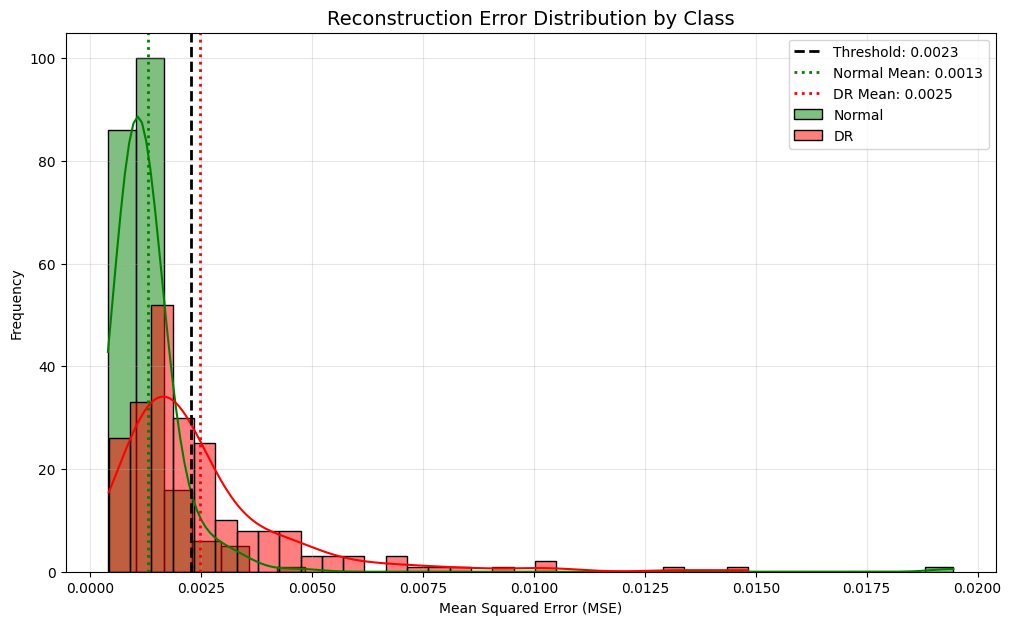


DETAILED CLASSIFICATION REPORT FOR AUTOENCODER MODEL:
--------------------------------------------------
Threshold used: 0.0023
              precision    recall  f1-score   support

      Normal       0.59      0.93      0.73       215
          DR       0.86      0.38      0.52       220

    accuracy                           0.65       435
   macro avg       0.73      0.66      0.63       435
weighted avg       0.73      0.65      0.62       435

--------------------------------------------------
Accuracy:    0.6529 (65.29%)
Precision:   0.8557 (85.57%)
Recall:      0.3773 (37.73%)
F1 Score:    0.5237 (52.37%)
Specificity: 0.9349 (93.49%)
AUC:         0.7770 (77.70%)
--------------------------------------------------


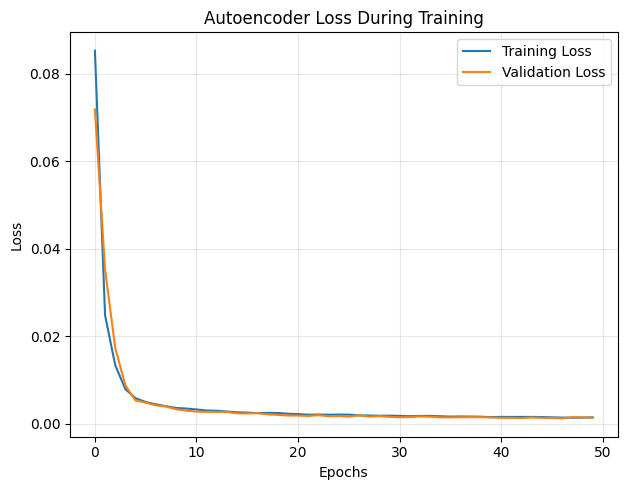

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Generate metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
specificity = confusion_matrix(test_labels, y_pred)[0,0] / (confusion_matrix(test_labels, y_pred)[0,0] + confusion_matrix(test_labels, y_pred)[0,1])

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, mse_losses)
roc_auc = auc(fpr, tpr)

# 1. Enhanced Normalized Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot both raw and normalized confusion matrices side by side
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted DR'],
            yticklabels=['Actual Normal', 'Actual DR'])
plt.title('Raw Counts', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted DR'],
            yticklabels=['Actual Normal', 'Actual DR'])
plt.title('Normalized by Row (Recall)', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.suptitle(f'Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Comprehensive Metrics Summary Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']
values = [accuracy, precision, recall, specificity, f1]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics, values, color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}',
             ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.15)
plt.title('Autoencoder Classification Performance Metrics', fontsize=14)
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.3)
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. ROC Curve with Annotations and AUC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2%})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Mark optimal threshold point (maximizing Youden's index: TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
            label=f'Optimal Threshold ({optimal_threshold:.4f})')

# Add annotations for key points
plt.annotate(f'Sensitivity: {tpr[optimal_idx]:.2%}\nSpecificity: {1-fpr[optimal_idx]:.2%}',
             xy=(fpr[optimal_idx], tpr[optimal_idx]), xytext=(fpr[optimal_idx]+0.1, tpr[optimal_idx]-0.1),
             arrowprops=dict(arrowstyle='->'), bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Autoencoder', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution of Reconstruction Errors with Threshold
plt.figure(figsize=(12, 7))
sns.histplot(mse_losses[test_labels == 0], color='green',
             label='Normal', kde=True, alpha=0.5, bins=30)
sns.histplot(mse_losses[test_labels == 1], color='red',
             label='DR', kde=True, alpha=0.5, bins=30)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2,
            label=f'Threshold: {threshold:.4f}')

# Add annotations for distributions
normal_mean = np.mean(mse_losses[test_labels == 0])
dr_mean = np.mean(mse_losses[test_labels == 1])
plt.axvline(normal_mean, color='green', linestyle=':', linewidth=2,
            label=f'Normal Mean: {normal_mean:.4f}')
plt.axvline(dr_mean, color='red', linestyle=':', linewidth=2,
            label=f'DR Mean: {dr_mean:.4f}')

plt.title('Reconstruction Error Distribution by Class', fontsize=14)
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Print detailed classification report
print("\nDETAILED CLASSIFICATION REPORT FOR AUTOENCODER MODEL:")
print("-" * 50)
print(f"Threshold used: {threshold:.4f}")
print(classification_report(test_labels, y_pred, target_names=['Normal', 'DR']))
print("-" * 50)
print(f"Accuracy:    {accuracy:.4f} ({accuracy:.2%})")
print(f"Precision:   {precision:.4f} ({precision:.2%})")
print(f"Recall:      {recall:.4f} ({recall:.2%})")
print(f"F1 Score:    {f1:.4f} ({f1:.2%})")
print(f"Specificity: {specificity:.4f} ({specificity:.2%})")
print(f"AUC:         {roc_auc:.4f} ({roc_auc:.2%})")
print("-" * 50)

# 6. Additional: Learning Curve (if you have training history)
# If you have history from model.fit():
if 'history' in locals() or 'history' in globals():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    # If you have custom metrics
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy During Training')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# 7. Model architecture summary (if model is available)
if 'model' in locals() or 'model' in globals():
    print("\nMODEL ARCHITECTURE SUMMARY:")
    print("-" * 50)
    model.summary()

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step

==== Random Sample of Test Images ====


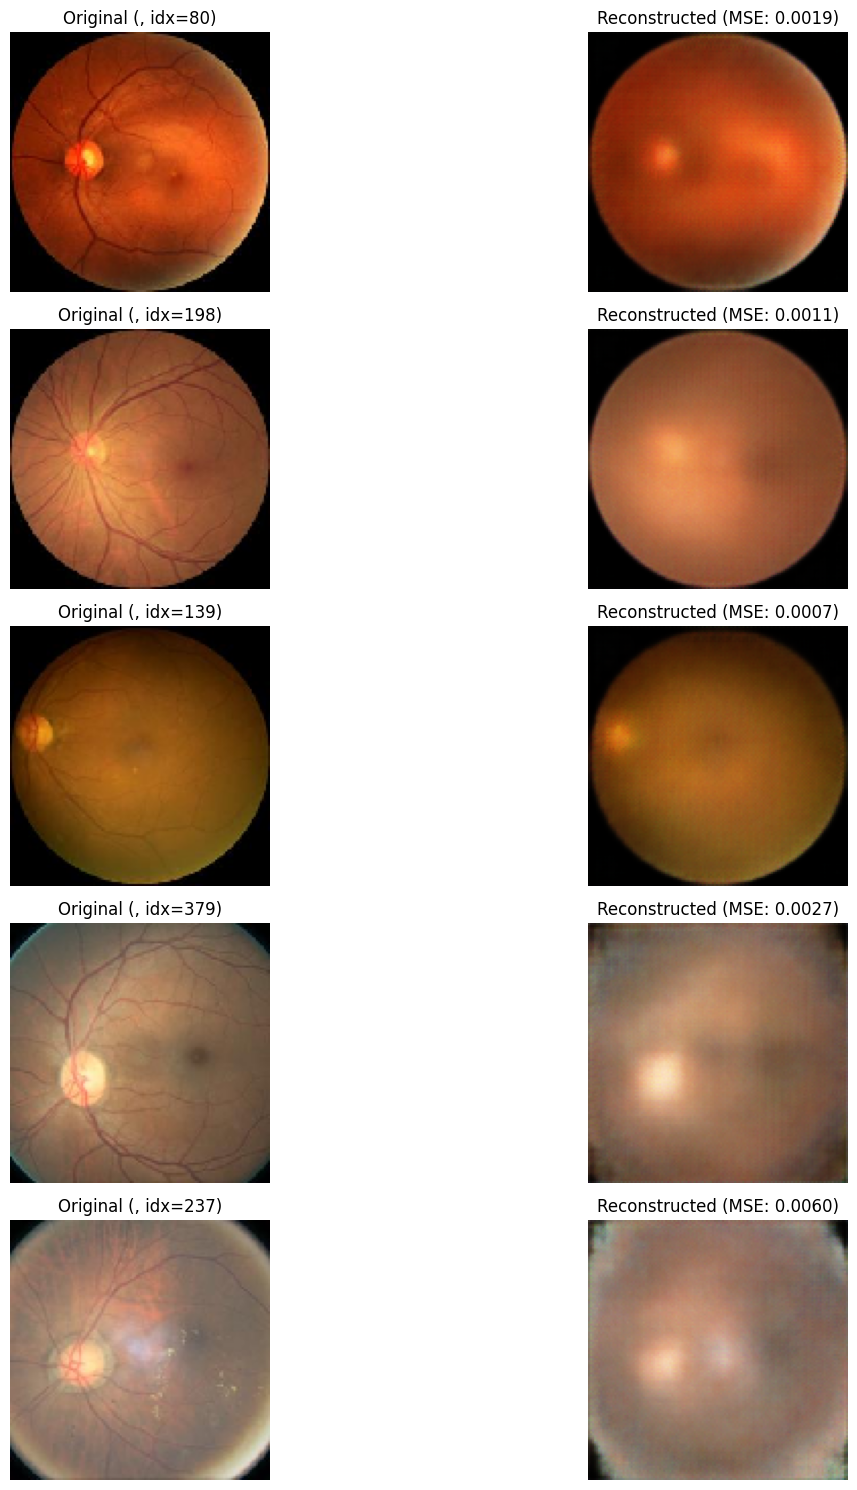


==== Normal Images and Reconstructions ====


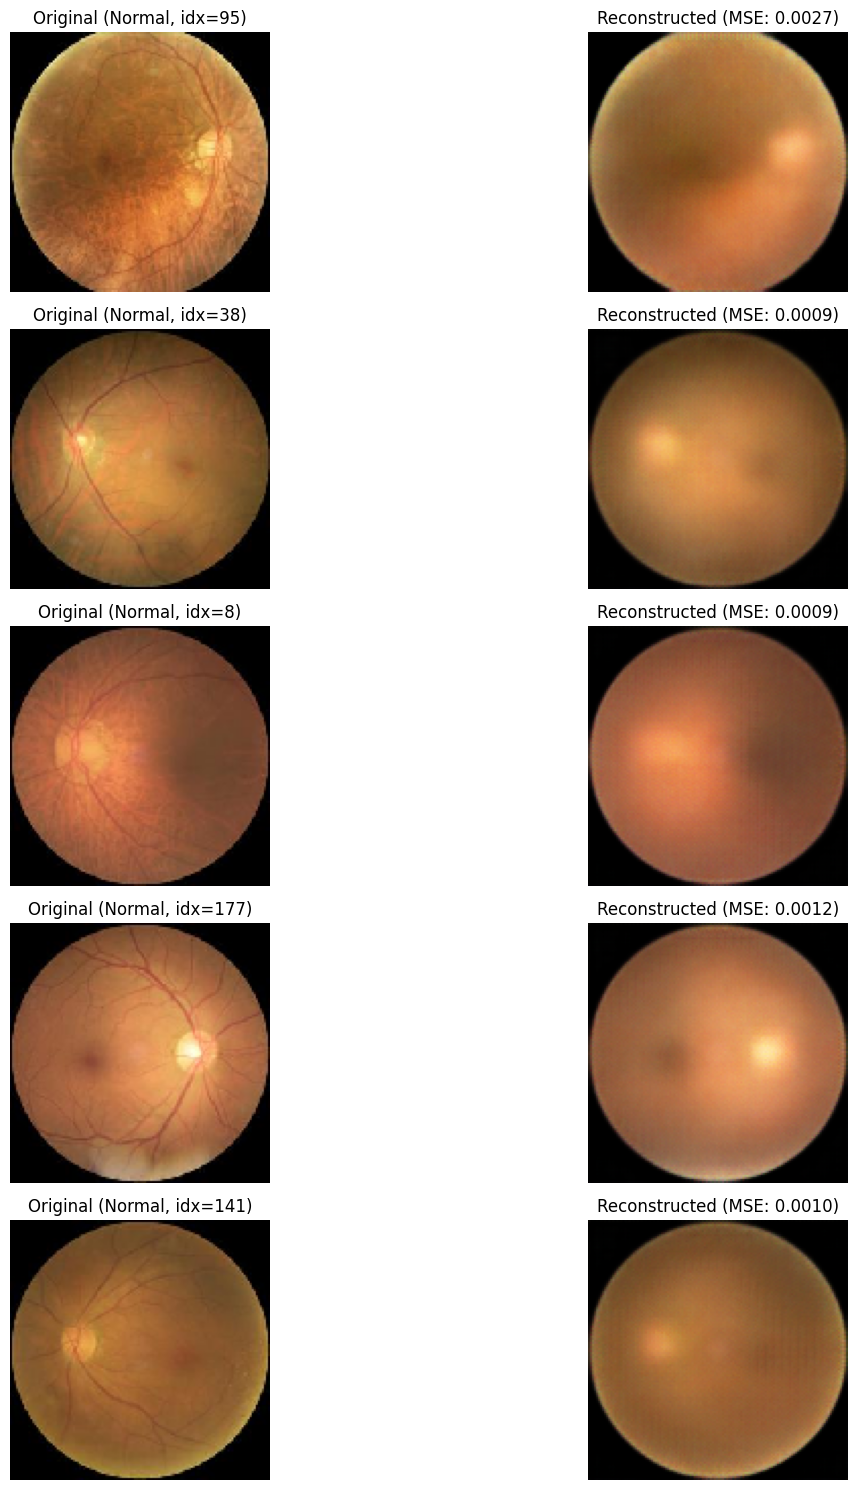


==== DR Images and Reconstructions ====


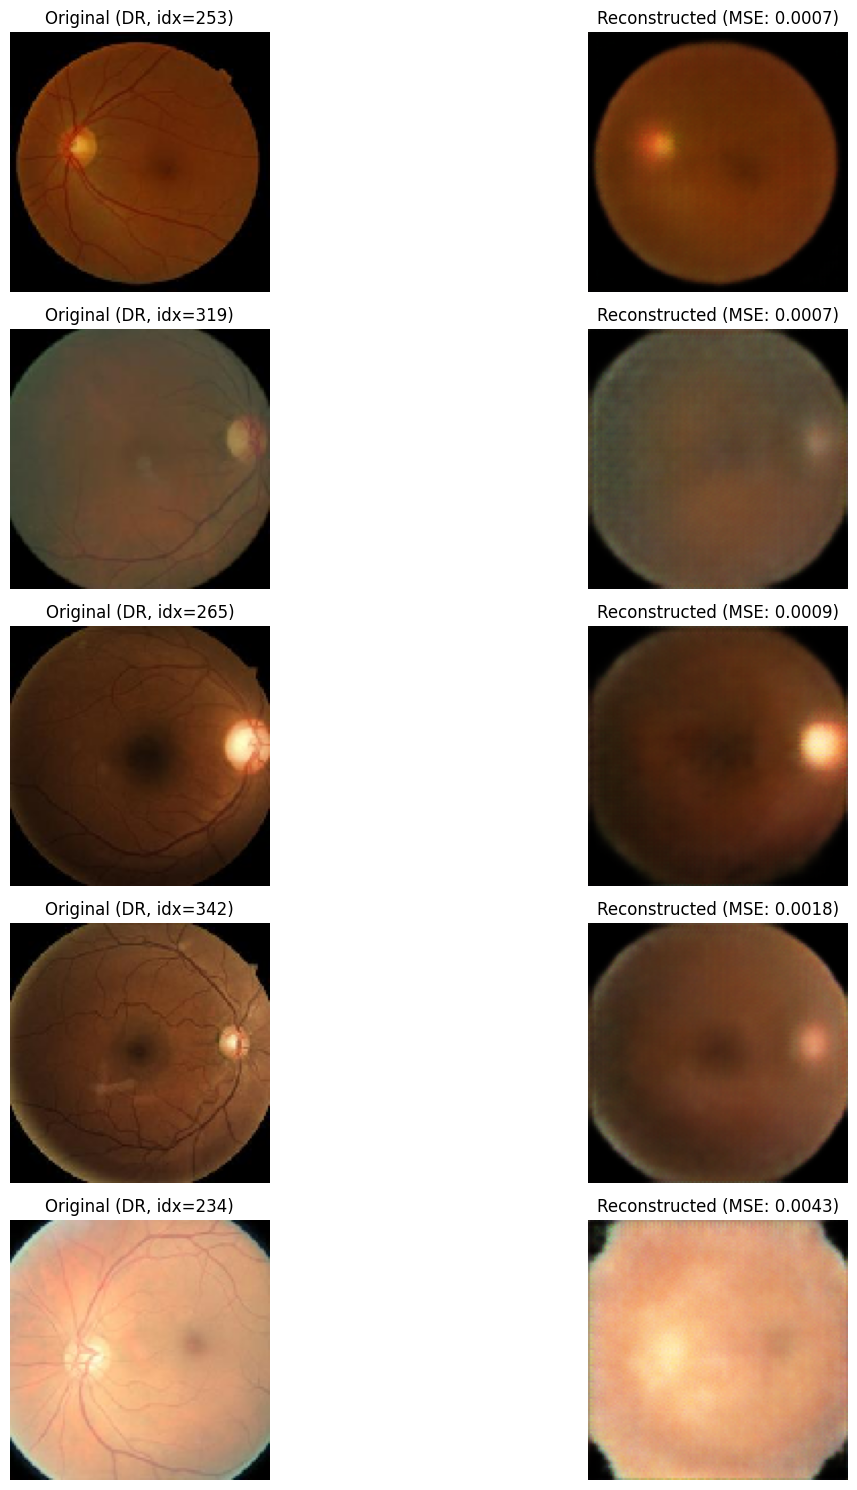


==== Reconstruction Error Distribution ====
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step


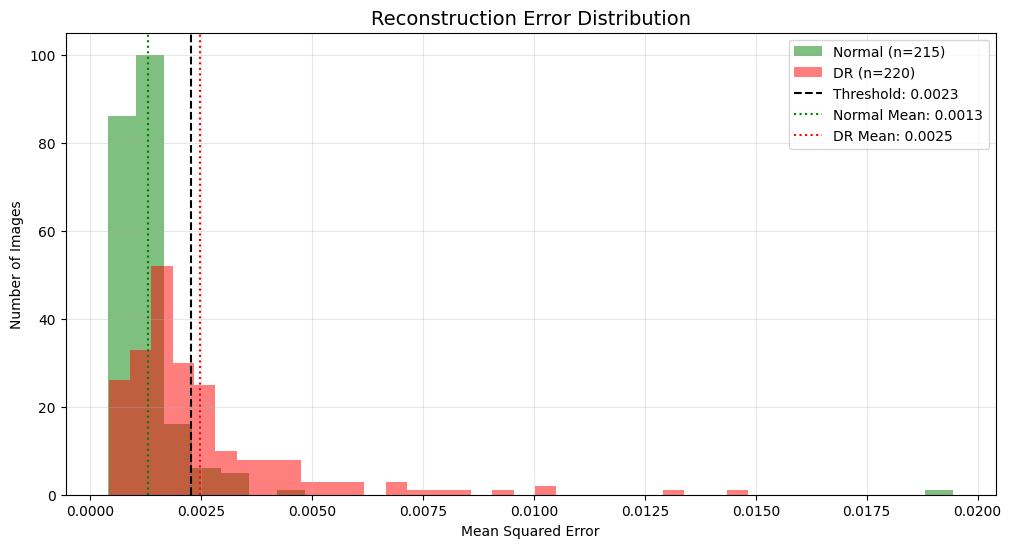

Normal images MSE - Mean: 0.0013, Std: 0.0014
DR images MSE - Mean: 0.0025, Std: 0.0020
Classification threshold: 0.0023
Normal images correctly classified: 201/215 (93.49%)
DR images correctly classified: 83/220 (37.73%)

==== Best Normal Reconstructions (Lowest MSE) ====


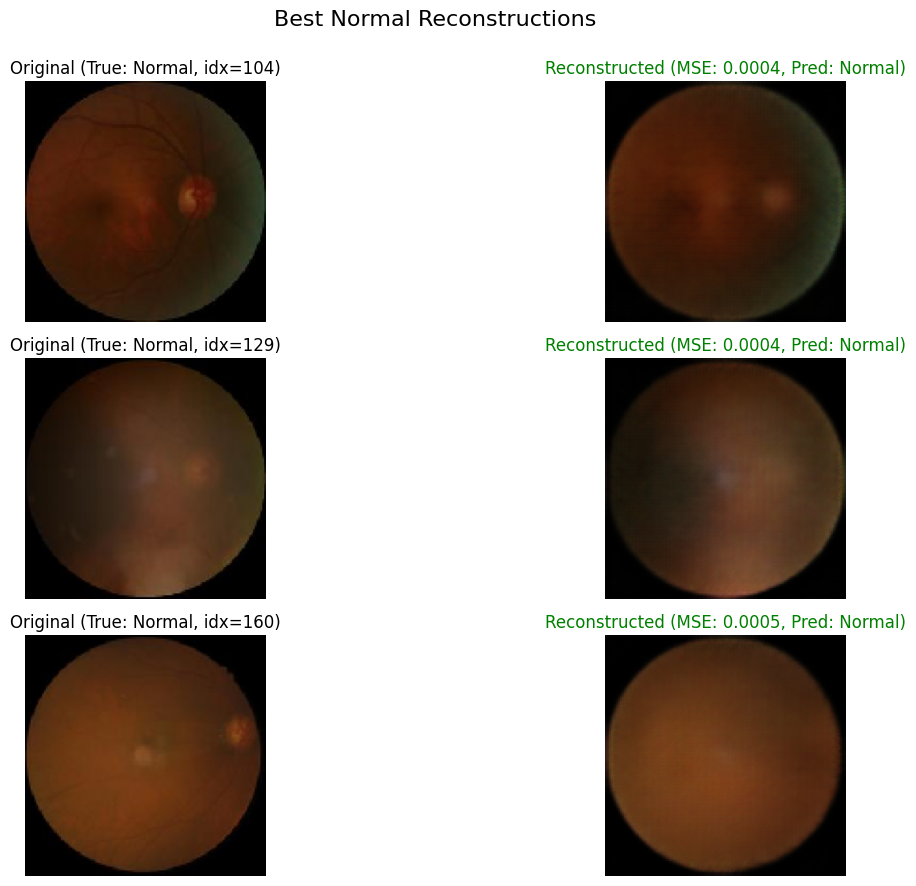


==== Worst Normal Reconstructions (Highest MSE) ====


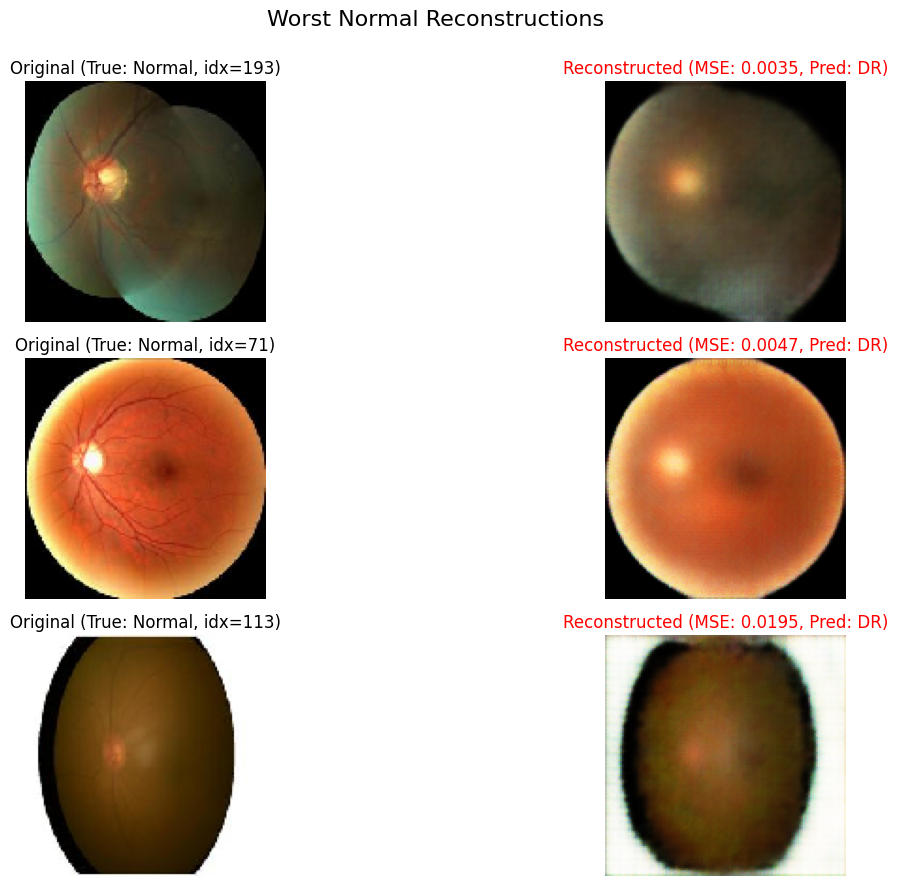


==== Best DR Reconstructions (Lowest MSE) ====


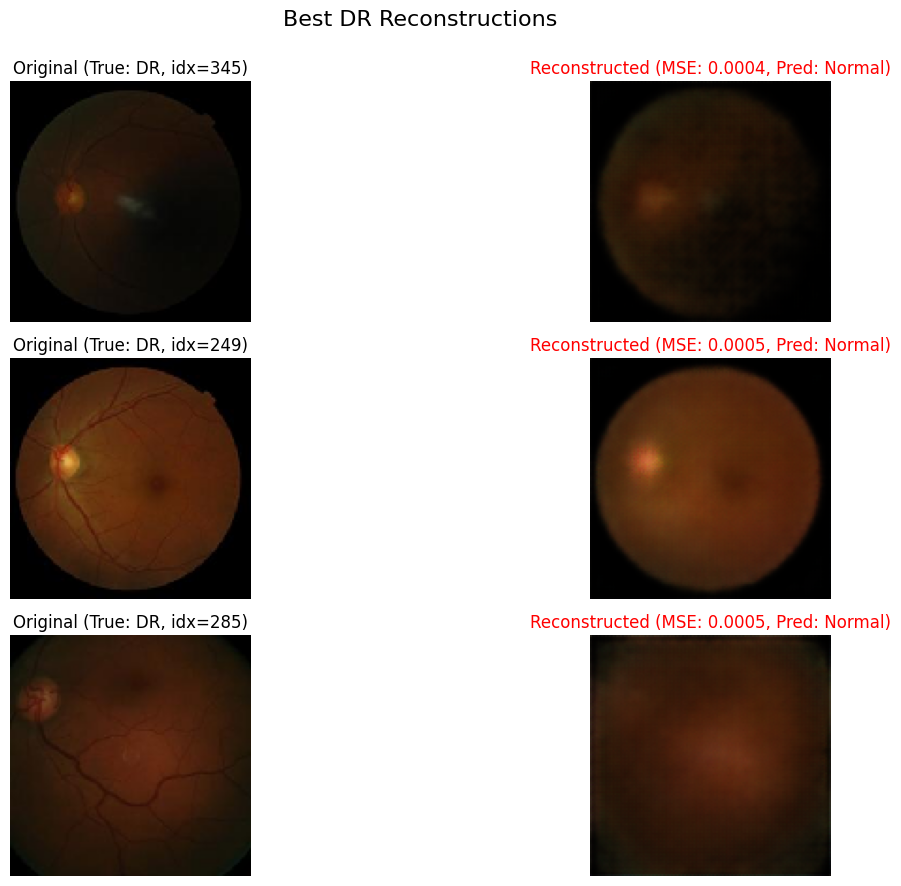


==== Worst DR Reconstructions (Highest MSE) ====


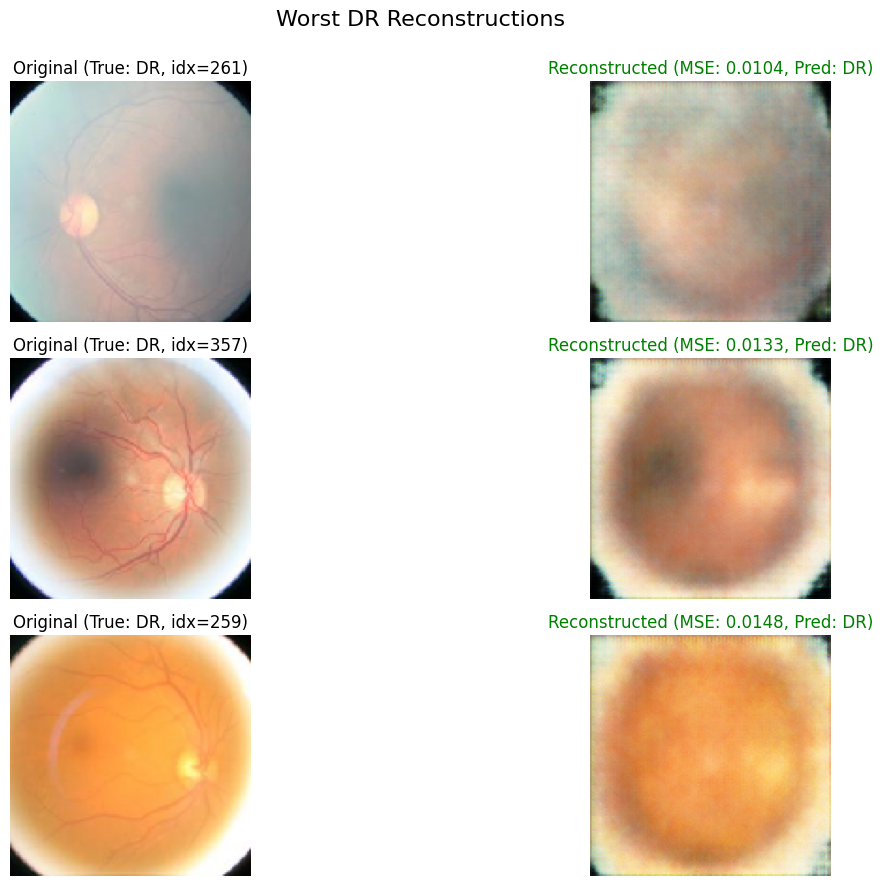


==== Misclassified Examples ====


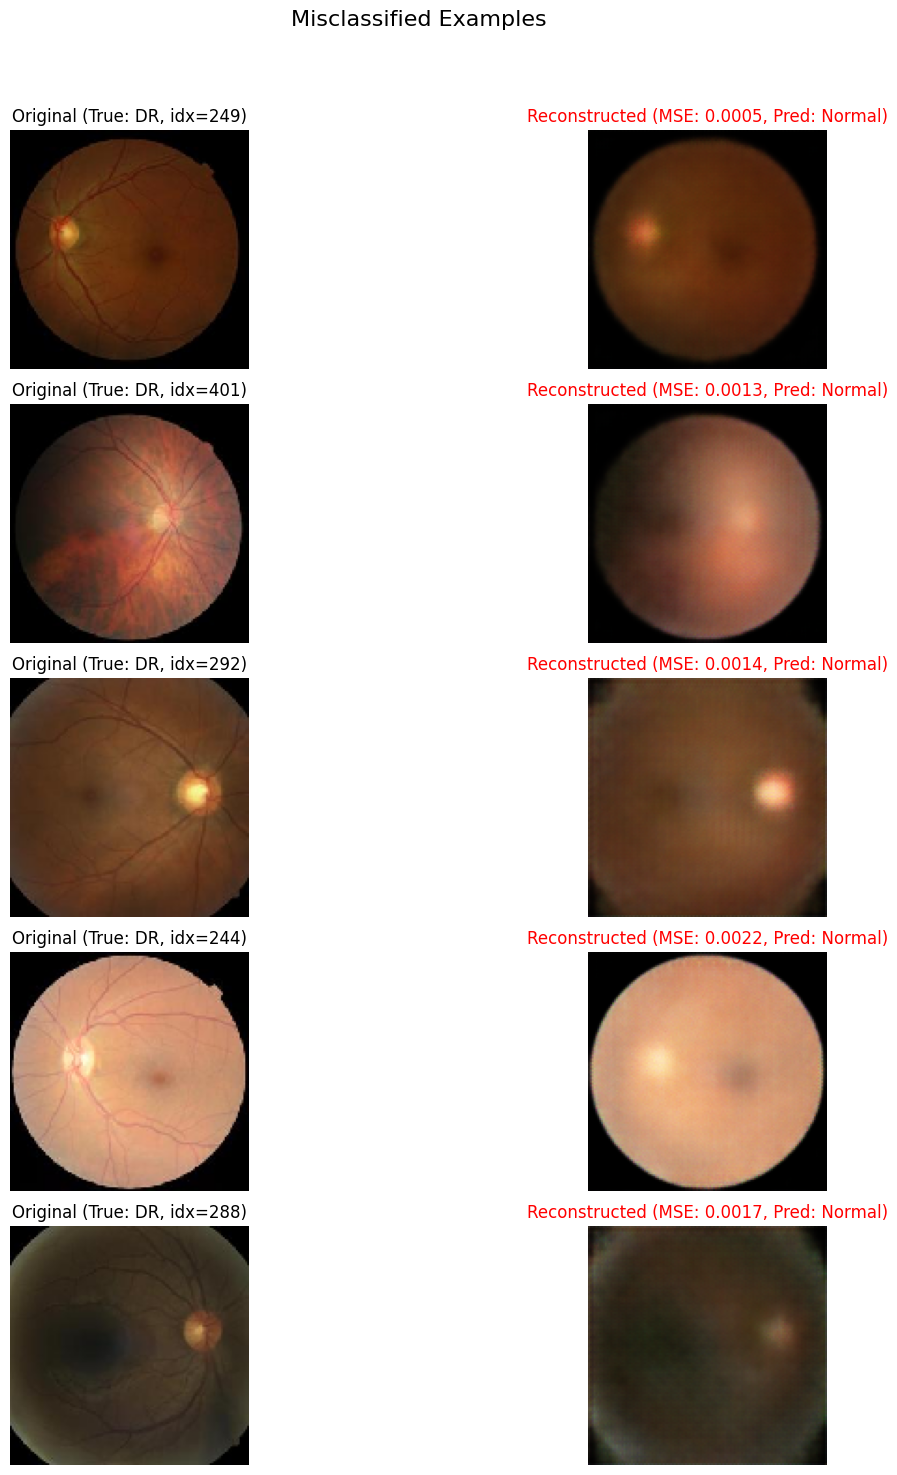


==== Reconstruction Performance Summary ====
------------------------------------------------------------
Total test images: 435
Normal images: 215
DR images: 220
Overall MSE (mean ± std): 0.0019 ± 0.0018
Classification threshold: 0.0023
------------------------------------------------------------
Accuracy: 0.6529 (65.29%)
Precision: 0.8557 (85.57%)
Recall/Sensitivity: 0.3773 (37.73%)
Specificity: 0.9349 (93.49%)
F1 Score: 0.5237 (52.37%)
------------------------------------------------------------


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_squared_error

# Function to visualize original vs reconstructed images
def visualize_reconstructions(original_images, reconstructed_images, labels, n_samples=5, class_name=""):
    """
    Visualize original vs reconstructed images with their MSE losses

    Parameters:
    -----------
    original_images : array of original images
    reconstructed_images : array of reconstructed images
    labels : array of true labels (0 for normal, 1 for DR)
    n_samples : number of samples to visualize
    class_name : name of the class being visualized
    """
    plt.figure(figsize=(15, 3*n_samples))

    # Get random indices for the specific class
    if class_name:
        indices = np.where(labels == (0 if class_name == "Normal" else 1))[0]
        indices = random.sample(list(indices), min(n_samples, len(indices)))
    else:
        indices = random.sample(range(len(original_images)), min(n_samples, len(original_images)))

    for i, idx in enumerate(indices):
        # Calculate MSE for this image
        mse = mean_squared_error(original_images[idx].flatten(), reconstructed_images[idx].flatten())

        # Original Image
        plt.subplot(n_samples, 2, 2*i+1)
        plt.imshow(original_images[idx])
        plt.title(f"Original ({class_name}, idx={idx})")
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(n_samples, 2, 2*i+2)
        plt.imshow(reconstructed_images[idx])
        plt.title(f"Reconstructed (MSE: {mse:.4f})")
        plt.axis('off')

    plt.tight_layout()
    class_name_safe = class_name.lower().replace(" ", "_") if class_name else "mixed"
    plt.savefig(f'reconstructions_{class_name_safe}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Function to plot reconstruction error distribution
def plot_reconstruction_errors(test_images, test_labels, model, threshold):
    """
    Plot the distribution of reconstruction errors for normal and DR images
    with the classification threshold

    Parameters:
    -----------
    test_images : array of test images
    test_labels : array of true labels (0 for normal, 1 for DR)
    model : trained autoencoder model
    threshold : classification threshold for anomaly detection
    """
    # Get reconstructed images
    reconstructed_images = model.predict(test_images)

    # Calculate MSE for each image
    mse_losses = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

    # Separate losses by class
    normal_losses = mse_losses[test_labels == 0]
    dr_losses = mse_losses[test_labels == 1]

    # Plot distributions
    plt.figure(figsize=(12, 6))

    # Plot histograms
    plt.hist(normal_losses, bins=30, alpha=0.5, color='green', label=f'Normal (n={len(normal_losses)})')
    plt.hist(dr_losses, bins=30, alpha=0.5, color='red', label=f'DR (n={len(dr_losses)})')

    # Add threshold line
    plt.axvline(x=threshold, color='black', linestyle='--',
                label=f'Threshold: {threshold:.4f}')

    # Add mean lines
    plt.axvline(x=np.mean(normal_losses), color='green', linestyle=':',
                label=f'Normal Mean: {np.mean(normal_losses):.4f}')
    plt.axvline(x=np.mean(dr_losses), color='red', linestyle=':',
                label=f'DR Mean: {np.mean(dr_losses):.4f}')

    plt.title('Reconstruction Error Distribution', fontsize=14)
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Number of Images')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('reconstruction_errors_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"Normal images MSE - Mean: {np.mean(normal_losses):.4f}, Std: {np.std(normal_losses):.4f}")
    print(f"DR images MSE - Mean: {np.mean(dr_losses):.4f}, Std: {np.std(dr_losses):.4f}")
    print(f"Classification threshold: {threshold:.4f}")

    # Calculate how many are correctly classified
    normal_correct = np.sum(normal_losses < threshold)
    dr_correct = np.sum(dr_losses >= threshold)

    print(f"Normal images correctly classified: {normal_correct}/{len(normal_losses)} ({normal_correct/len(normal_losses):.2%})")
    print(f"DR images correctly classified: {dr_correct}/{len(dr_losses)} ({dr_correct/len(dr_losses):.2%})")

# Get predictions (reconstructions) on test images
reconstructed_test_images = autoencoder.predict(test_images)

# Calculate MSE losses for each image
mse_losses = np.mean(np.square(test_images - reconstructed_test_images), axis=(1, 2, 3))

# Use your threshold (assuming it's already defined)
# If not, you can calculate it from the ROC curve or just use the mean of all losses
if 'threshold' not in locals() and 'threshold' not in globals():
    # Calculate threshold as the optimal point from ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(test_labels, mse_losses)
    optimal_idx = np.argmax(tpr - fpr)
    threshold = thresholds[optimal_idx]
    print(f"Calculated optimal threshold: {threshold:.4f}")

# Generate predictions based on threshold
y_pred = (mse_losses >= threshold).astype(int)

# 1. Visualize some random test images and their reconstructions
print("\n==== Random Sample of Test Images ====")
visualize_reconstructions(test_images, reconstructed_test_images, test_labels, n_samples=5)

# 2. Visualize Normal images and their reconstructions
print("\n==== Normal Images and Reconstructions ====")
visualize_reconstructions(test_images, reconstructed_test_images, test_labels, n_samples=5, class_name="Normal")

# 3. Visualize DR images and their reconstructions
print("\n==== DR Images and Reconstructions ====")
visualize_reconstructions(test_images, reconstructed_test_images, test_labels, n_samples=5, class_name="DR")

# 4. Plot reconstruction error distributions
print("\n==== Reconstruction Error Distribution ====")
plot_reconstruction_errors(test_images, test_labels, autoencoder, threshold)

# 5. Find the best and worst reconstructions for each class
def find_extreme_reconstructions(images, reconstructed, labels, threshold, n=3):
    """
    Find the best and worst reconstructions for each class
    """
    mse_losses = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))

    # Get indices for each class
    normal_indices = np.where(labels == 0)[0]
    dr_indices = np.where(labels == 1)[0]

    # Get losses for each class
    normal_losses = mse_losses[normal_indices]
    dr_losses = mse_losses[dr_indices]

    # Find best (lowest MSE) and worst (highest MSE) indices
    best_normal_idx = normal_indices[np.argsort(normal_losses)[:n]]
    worst_normal_idx = normal_indices[np.argsort(normal_losses)[-n:]]
    best_dr_idx = dr_indices[np.argsort(dr_losses)[:n]]
    worst_dr_idx = dr_indices[np.argsort(dr_losses)[-n:]]

    return {
        'best_normal': best_normal_idx,
        'worst_normal': worst_normal_idx,
        'best_dr': best_dr_idx,
        'worst_dr': worst_dr_idx
    }

# Find extreme cases
extreme_cases = find_extreme_reconstructions(test_images, reconstructed_test_images, test_labels, threshold)

# 6. Visualize best and worst reconstructions
def visualize_extreme_cases(original_images, reconstructed_images, indices, title):
    """
    Visualize best/worst reconstructions with their MSE losses
    """
    n = len(indices)
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(indices):
        # Calculate MSE for this image
        mse = mean_squared_error(original_images[idx].flatten(), reconstructed_images[idx].flatten())
        prediction = "Normal" if mse < threshold else "DR"
        true_label = "Normal" if test_labels[idx] == 0 else "DR"
        correct = prediction == true_label

        # Original Image
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(original_images[idx])
        plt.title(f"Original (True: {true_label}, idx={idx})")
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(reconstructed_images[idx])
        color = "green" if correct else "red"
        plt.title(f"Reconstructed (MSE: {mse:.4f}, Pred: {prediction})", color=color)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    # Save figure with a filename based on the title
    safe_title = title.lower().replace(" ", "_").replace("/", "_")
    plt.savefig(f'{safe_title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize best normal reconstructions
print("\n==== Best Normal Reconstructions (Lowest MSE) ====")
visualize_extreme_cases(test_images, reconstructed_test_images,
                         extreme_cases['best_normal'],
                         "Best Normal Reconstructions")

# Visualize worst normal reconstructions
print("\n==== Worst Normal Reconstructions (Highest MSE) ====")
visualize_extreme_cases(test_images, reconstructed_test_images,
                         extreme_cases['worst_normal'],
                         "Worst Normal Reconstructions")

# Visualize best DR reconstructions
print("\n==== Best DR Reconstructions (Lowest MSE) ====")
visualize_extreme_cases(test_images, reconstructed_test_images,
                         extreme_cases['best_dr'],
                         "Best DR Reconstructions")

# Visualize worst DR reconstructions
print("\n==== Worst DR Reconstructions (Highest MSE) ====")
visualize_extreme_cases(test_images, reconstructed_test_images,
                         extreme_cases['worst_dr'],
                         "Worst DR Reconstructions")

# 7. Visualize misclassified examples
def visualize_misclassified(test_images, reconstructed_images, test_labels, mse_losses, threshold, n=5):
    """
    Visualize misclassified examples
    """
    # Get predictions
    y_pred = (mse_losses >= threshold).astype(int)

    # Find misclassified indices
    misclassified_indices = np.where(y_pred != test_labels)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified examples found!")
        return

    # Select a random subset if there are too many
    if len(misclassified_indices) > n:
        misclassified_indices = np.random.choice(misclassified_indices, n, replace=False)

    plt.figure(figsize=(15, 3*len(misclassified_indices)))

    for i, idx in enumerate(misclassified_indices):
        # Calculate MSE for this image
        mse = mse_losses[idx]
        true_label = "Normal" if test_labels[idx] == 0 else "DR"
        pred_label = "Normal" if y_pred[idx] == 0 else "DR"

        # Original Image
        plt.subplot(len(misclassified_indices), 2, 2*i+1)
        plt.imshow(test_images[idx])
        plt.title(f"Original (True: {true_label}, idx={idx})")
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(len(misclassified_indices), 2, 2*i+2)
        plt.imshow(reconstructed_images[idx])
        plt.title(f"Reconstructed (MSE: {mse:.4f}, Pred: {pred_label})", color='red')
        plt.axis('off')

    plt.suptitle("Misclassified Examples", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize misclassified examples
print("\n==== Misclassified Examples ====")
visualize_misclassified(test_images, reconstructed_test_images, test_labels, mse_losses, threshold)

# 8. Summary of Reconstruction Performance
print("\n==== Reconstruction Performance Summary ====")
print("-" * 60)
print(f"Total test images: {len(test_images)}")
print(f"Normal images: {np.sum(test_labels == 0)}")
print(f"DR images: {np.sum(test_labels == 1)}")
print(f"Overall MSE (mean ± std): {np.mean(mse_losses):.4f} ± {np.std(mse_losses):.4f}")
print(f"Classification threshold: {threshold:.4f}")
print("-" * 60)

# Calculate accuracy metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
cm = confusion_matrix(test_labels, y_pred)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print(f"Accuracy: {accuracy:.4f} ({accuracy:.2%})")
print(f"Precision: {precision:.4f} ({precision:.2%})")
print(f"Recall/Sensitivity: {recall:.4f} ({recall:.2%})")
print(f"Specificity: {specificity:.4f} ({specificity:.2%})")
print(f"F1 Score: {f1:.4f} ({f1:.2%})")
print("-" * 60)